## Начало 

Проверим точность простой модели, состоящей из 3-х свёрточных слоёв.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import pickle
import methods

Зададим место, где лежат файлы.

In [2]:
DATA_FOLDER = "data"
CATEGORY_1 = "cat"
CATEGORY_2 = "dog"

## Взглянем на данные 

cat training data length:  7999
dog training data length:  7999
cat validation data length:  2001
dog validation data length:  2001
cat test data length:  2499
dog test data length:  2499


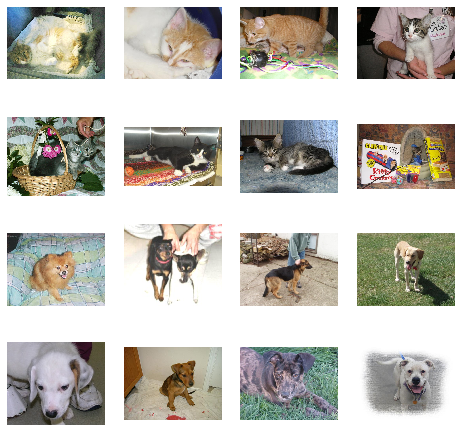

In [3]:
methods.visualize_data(DATA_FOLDER, CATEGORY_1, CATEGORY_2)

## Подготовим данные

In [21]:
image_size = 160 # All images will be resized to 150x150
batch_size = 1

train_datagen = ImageDataGenerator(rescale = 1/255)
validation_datagen = ImageDataGenerator(rescale = 1/255)
test_datagen = ImageDataGenerator(rescale = 1/255)

train_generator = train_datagen.flow_from_directory(
        DATA_FOLDER + '/train1',
        target_size = (image_size, image_size),
        batch_size = batch_size,
        class_mode = 'binary'
)

validation_generator = validation_datagen.flow_from_directory(
        DATA_FOLDER + '/validation1',
        target_size = (image_size, image_size),
        batch_size = batch_size,
        class_mode = 'binary'
)

test_generator = test_datagen.flow_from_directory(
        DATA_FOLDER + '/test1',
        target_size = (image_size, image_size),
        batch_size = batch_size,
        shuffle=False,
        class_mode = "binary"
)

Found 10 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
Found 4 images belonging to 2 classes.


## Построим и обучим модель 

In [5]:
input_shape = (image_size, image_size, 3)

In [6]:
input_shape = (image_size, image_size, 3)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [15]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Lambda(lambda x: x, input_shape=input_shape))
model.add(tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=input_shape))
model.add(tf.keras.layers.MaxPooling2D(2, 2))
model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2, 2))
model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2, 2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 160, 160, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 158, 158, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 79, 79, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 77, 77, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 38, 38, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 36, 36, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 18, 18, 32)        0         
__________

In [9]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

In [10]:
epochs = 2
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

In [11]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch = steps_per_epoch,
      epochs = epochs,
      workers = 4,
      validation_data = validation_generator,
      validation_steps = validation_steps)

Epoch 1/2
10/10 [==============================] - 1s 128ms/step - loss: 8.1253 - acc: 0.5000 - val_loss: 6.8685 - val_acc: 0.5000
Epoch 2/2
10/10 [==============================] - 1s 74ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 6.9818 - val_acc: 0.5000


##  Сохраним результаты

Сохраним модель.

In [22]:
model.save("models/basicConvolution/basicConvolution.h5")

In [27]:
saved_model_path = "models/basicConvolution/"
tf.contrib.saved_model.save_keras_model(model, saved_model_path)

INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: models/basicConvolution\temp-b'1563872090'\saved_model.pb


b'models/basicConvolution/1563872090'

Сохраним историю обучения.

In [12]:
with open("histories/basicConvolution/basicConvolutionHistory", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

## Восстановим результаты 

Восстановим модель.

In [23]:
model_loaded = keras.models.load_model("models/basicConvolution/basicConvolution.h5")

In [25]:
model_loaded.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

In [26]:
model_loaded.predict_generator(test_generator)

array([[0.46534002],
       [0.43637627],
       [0.46254995],
       [0.4427455 ]], dtype=float32)

Восстановим историю обучения.

In [14]:
with open("histories/basicConvolution/basicConvolutionHistory", 'rb') as file_pi:
    history_loaded = pickle.load(file_pi)

## Посмотрим результаты 

Посмотрим графики обучения.

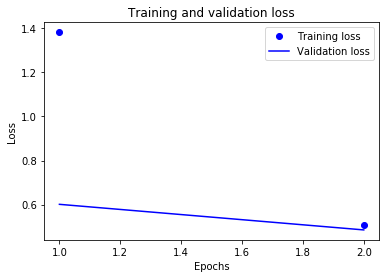

In [15]:
methods.loss(history_loaded)

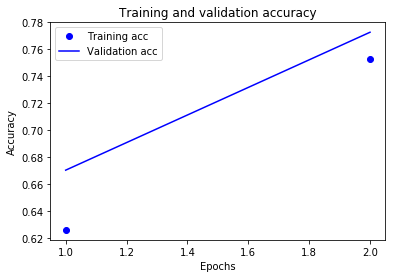

In [16]:
methods.acc(history_loaded)

Оценим параметры модели.

In [17]:
methods.AccRecPrec(model_loaded.predict_generator(test_generator), test_generator.classes)

D:\Programms\Anaconda3\envs\tf_gpu\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262146 bytes but only got 0. Skipping tag 2
  " Skipping tag %s" % (size, len(data), tag))
D:\Programms\Anaconda3\envs\tf_gpu\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262151 bytes but only got 0. Skipping tag 56
  " Skipping tag %s" % (size, len(data), tag))
D:\Programms\Anaconda3\envs\tf_gpu\lib\site-packages\PIL\TiffImagePlugin.py:780: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 0. 
  warnings.warn(str(msg))
D:\Programms\Anaconda3\envs\tf_gpu\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 80000 bytes but only got 0. Skipping tag 64640
  " Skipping tag %s" % (size, len(data), tag))
D:\Programms\Anaconda3\envs\tf_gpu\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF 

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
accuracy:  0.7617047
recall:    0.8147259
precision: 0.73661363
f1:        0.7737032198786623
